# Emotion Detection - JAFFE

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import losses, optimizers, metrics

## Data Processing

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create the main 'data' directory
if not os.path.exists('data'):
    os.makedirs('data')

# Create 'train' and 'test' subdirectories
if not os.path.exists('data/train'):
    os.makedirs('data/train')
if not os.path.exists('data/test'):
    os.makedirs('data/test')

# Define the source directory
source_dir = '/content/drive/MyDrive/CollabData/JAFFE'

# Define the emotion labels
emotions = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']

# Create directories for each emotion within 'train' and 'test'
for emotion in emotions:
    if not os.path.exists(f'data/train/{emotion}'):
        os.makedirs(f'data/train/{emotion}')
    if not os.path.exists(f'data/test/{emotion}'):
        os.makedirs(f'data/test/{emotion}')

# List all files in the source directory
all_files = os.listdir(source_dir)

# Group files by emotion and store split files
emotion_split_files = {}
for filename in all_files:
    parts = filename.split('.')
    if len(parts) > 1:
        # The emotion seems to be the second part before the number
        # Adjust this logic if the naming convention is different
        emotion_code = parts[1][:-1] # Remove the trailing digit (e.g., 'AN1' -> 'AN')
        if emotion_code in emotions:
            if emotion_code not in emotion_split_files:
                emotion_split_files[emotion_code] = []
            emotion_split_files[emotion_code].append(filename)

# Split and copy files for each emotion
train_counts = {}
test_counts = {}
for emotion, files in emotion_split_files.items():
    if not files:
        print(f"No files found for emotion: {emotion}")
        continue

    # Split files into training and testing sets
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    train_counts[emotion] = len(train_files)
    test_counts[emotion] = len(test_files)

    # Copy training files
    for file in train_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('data/train', emotion, file)
        shutil.copy2(src_path, dest_path) # Use copy2 to preserve metadata

    # Copy testing files
    for file in test_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('data/test', emotion, file)
        shutil.copy2(src_path, dest_path)

print("Data splitting and organization complete.")
print(f"Train images per emotion: {train_counts}")
print(f"Test images per emotion: {test_counts}")

Data splitting and organization complete.
Train images per emotion: {'FE': 25, 'HA': 24, 'NE': 24, 'SA': 24, 'SU': 24, 'AN': 24, 'DI': 23}
Test images per emotion: {'FE': 7, 'HA': 7, 'NE': 6, 'SA': 7, 'SU': 6, 'AN': 6, 'DI': 6}


In [46]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

train_dir = 'data/train'
test_dir ='data/test'

img_height = 224
img_width = 224
batch_size = 32

# Function to load images as NumPy arrays
def load_images_from_directory(directory, image_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    label_map = {name: index for index, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load training and validation data
train_images, train_labels, class_names = load_images_from_directory(train_dir)
validation_images, validation_labels, _ = load_images_from_directory(test_dir)

# Convert labels to categorical
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=len(class_names))
validation_labels_one_hot = keras.utils.to_categorical(validation_labels, num_classes=len(class_names))

# Create TensorFlow datasets
train_generator = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(batch_size).shuffle(buffer_size=100)
validation_generator = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels_one_hot)).batch(batch_size)

print("Data generators created successfully.")

Data generators created successfully.


(32, 224, 224, 3)


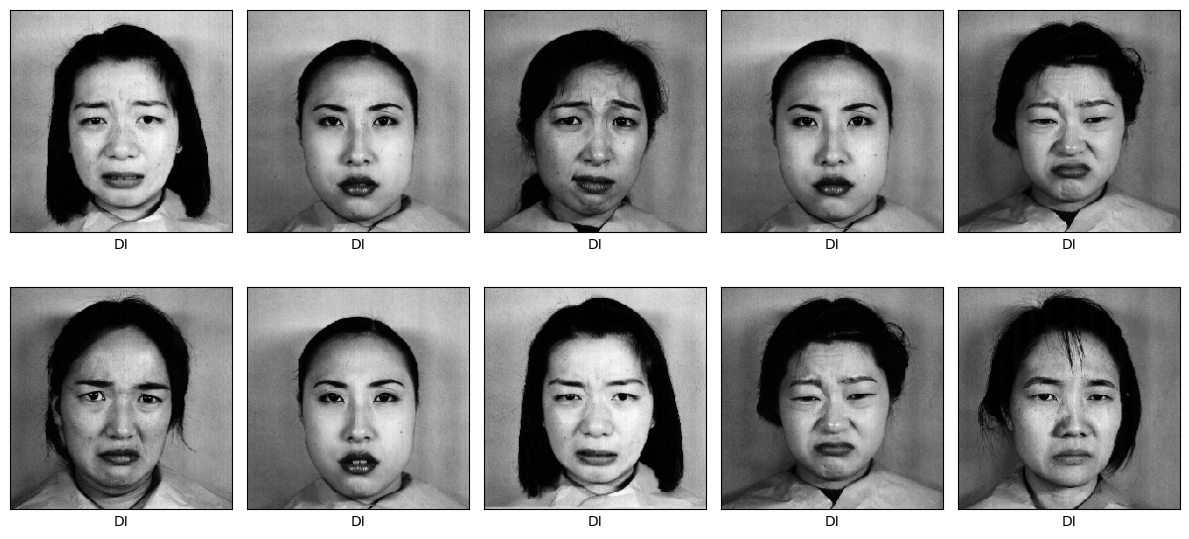

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import tensorflow

# Assuming 'train_generator' is available from your previous code setup
# and 'class_names' list is available from the data loading step
# The 'classes' dictionary should reflect the actual class names
classes = {i: name for i, name in enumerate(class_names)}


# Use the 'train_generator' to get a batch
for images, cls_true_one_hot in train_generator.take(1): # Take one batch
    print(images.shape)
    # images and labels are already TensorFlow tensors

    # Convert one-hot encoded labels back to integer labels
    cls_true = tf.argmax(cls_true_one_hot, axis=1).numpy() # Convert to numpy array

    break # Get only the first batch for display

fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Added figsize for better display
axes = axes.flatten() # Flatten the 2x5 array of axes for easier iteration

# Get the number of images in the batch
num_images_in_batch = images.shape[0]

for i, ax in enumerate(axes): # Using 'ax' directly from flattened axes
    if i < num_images_in_batch: # Only display if there is an image in the batch
        # Plot image.
        # TensorFlow images are typically float [0, 255] or [0, 1]. Assuming [0, 255] from load_img
        img_display = images[i].numpy().astype(np.uint8) # Convert tensor to NumPy array (H, W, C) and to uint8

        ax.imshow(img_display)

        # Show true class.
        true_label_idx = cls_true[i] # Get the integer label

        # Use the 'classes' dictionary for mapping numerical label to string name
        xlabel = classes[true_label_idx]

        # Set the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Hide unused subplots
        ax.axis('off')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Model Development

In [56]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    11,075,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,133,959 (42.47 MB)

 Trainable params: 11,133,959 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [57]:
model.compile(optimizer=optimizers.Adam(2.5e-5),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy']
             )

history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=1
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.0000e+00 - loss: 66.2694 - val_accuracy: 0.1250 - val_loss: 59.2903
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.2077 - loss: 34.4239 - val_accuracy: 0.1562 - val_loss: 45.2262
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3058 - loss: 31.3899 - val_accuracy: 0.0000e+00 - val_loss: 35.0114
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1295 - loss: 18.8587 - val_accuracy: 0.1875 - val_loss: 7.0345
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1977 - loss: 12.9650 - val_accuracy: 0.2500 - val_loss: 12.5395
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.2349 - loss: 12.8027 - val_accuracy: 0.0625 - val_loss: 12.7807
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1772 - loss: 12.2317 - val_accuracy: 0.3750 - val_loss: 5.1994
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.2130 - loss: 7.9496 - val_accuracy: 0.2812

KeyboardInterrupt: 

## Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, dashes=[2, 2, 10, 2], label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, dashes=[2, 2, 10, 2], label='Training losses')
plt.plot(epochs, val_loss, 'g', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Pre-Trained Model (VGG 16) Development

### Model Development

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [ ]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

In [ ]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.Adam(lr=5e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator,
                              steps_per_epoch=6,
                              epochs=5,
                              validation_data=validation_generator,
                              validation_steps=1)

In [ ]:
conv_base = model.layers[0]

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Model Training

In [ ]:
model.compile(
    optimizer=optimizers.Adam(lr=5e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

history = model.fit_generator(train_generator,
                              steps_per_epoch=6,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=1)

### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, dashes=[2, 2, 10, 2], label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, dashes=[2, 2, 10, 2], label='Training losses')
plt.plot(epochs, val_loss, 'g', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('fully_trained_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('fully_trained_model.h5')

### Accuracy Prediction

In [ ]:
from keras.models import load_model
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

labels = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

model = load_model('fully_trained_model.h5')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
test_dir ="data/test"


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size=24  # put batch size == total data
)

In [ ]:
result = [[0 for _ in range(7)] for _ in range(7)]


data, labels = test_generator.next()
labels = np.argmax(labels, axis=1)

predictions = model.predict(data)
predictions = np.argmax(predictions, axis=1)

for i in range(len(predictions)):
    result[labels[i]][predictions[i]] += 1

In [ ]:
result

In [ ]:
import os

for root, dirs, files in os.walk('data/train'):
    print(f"Directory: {root}")
    print(f"Files: {files}")